In [1]:
import pandas as pd
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
#import getTaskBetas
from sklearn.preprocessing import StandardScaler
#import torch
#from torch import nn
#from torch.utils.data import DataLoader
import nibabel as nib

# Project directories
dataDir = '/projects/f_mc1689_1/AgingHubs/data'
scriptsDir = '/projects/f_mc1689_1/AgingHubs/docs/scripts'

# Subject numbers and basic info
subjectsFile = f'{scriptsDir}/subjects_grant.tsv'
subjectsDF = pd.read_csv(subjectsFile,sep='\t',index_col='subjects')
subjGroup = subjectsDF['group'].values
subjList = subjectsDF.index.values
nSubjs = {'all':len(subjList), 'YA':len(subjList[subjGroup=='YA']), 'OA':len(subjList[subjGroup=='OA'])}

# fMRI run names
allRuns = ['rfMRI_REST1_AP','rfMRI_REST2_AP','rfMRI_REST1_PA','rfMRI_REST2_PA','tfMRI_VISMOTOR_PA','tfMRI_CARIT_PA','tfMRI_FACENAME_PA']
restRuns = ['rfMRI_REST1_AP','rfMRI_REST2_AP','rfMRI_REST1_PA','rfMRI_REST2_PA']

# Order of parcels by network
#parcType = 'cortex_subcortex'
parcType = 'cortex'
parcOrderFile = f'{scriptsDir}/cabnp/{parcType}_community_order.txt'
parcOrder = pd.read_csv(parcOrderFile, sep='\t', header=None)[0] - 1

if parcType == 'cortex_subcortex':
    nNodes = 718
elif parcType == 'cortex':
    nNodes = 360
nEdges = ((nNodes**2) - nNodes)//2

nodes = np.asarray(range(nNodes))

# More network info
netInfoFile = f'{scriptsDir}/cabnp/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR_LabelKey.txt'
netInfo = pd.read_csv(netInfoFile, sep='\t')
print(netInfo)
netInfo = netInfo.iloc[parcOrder]
print(netInfo)
nodeLabels = netInfo['LABEL'].values
nodeNetKeys = netInfo['NETWORKKEY'].values - 1
nodeNets = netInfo['NETWORK'].values
networks = pd.unique(netInfo['NETWORK'])
nNets = len(networks)

netColors = np.empty((nNets,3))
for k,net in enumerate(networks):
    netColors[k,0] = netInfo.loc[netInfo['NETWORK'] == net, 'RED'].values[0]
    netColors[k,1] = netInfo.loc[netInfo['NETWORK'] == net, 'GREEN'].values[0]
    netColors[k,2] = netInfo.loc[netInfo['NETWORK'] == net, 'BLUE'].values[0]
    
nodeNetColors = np.empty((nNodes,3))
nodeNetColors[:,0] = netInfo['RED'].values
nodeNetColors[:,1] = netInfo['GREEN'].values
nodeNetColors[:,2] = netInfo['BLUE'].values

# Vertex assignments
##vertexFile = f'{scriptsDir}/cabnp/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_netassignments_LR.dscalar.nii'
#vertexFile = f'{scriptsDir}/cabnp/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR.dscalar.nii'

#vertexLabels = np.squeeze(nib.load(vertexFile).get_fdata())

#def loadVertexParcelActivations(data,parcel,vlabels=vertexLabels):
#    idx = np.where(vlabels==parcel)[0]
#    data = np.array((data))
#    return data[:,idx]
    
print('Subjects:\t',nSubjs)
print('Nodes:\t\t',nNodes)

     INDEX  KEYVALUE                           LABEL    RED  GREEN  BLUE  \
0        1         1                Visual1-04_L-Ctx  0.000   0.00   1.0   
1        2         2                Visual2-28_L-Ctx  0.392   0.00   1.0   
2        3         3                Visual2-29_L-Ctx  0.392   0.00   1.0   
3        4         4                Visual2-30_L-Ctx  0.392   0.00   1.0   
4        5         5                Visual2-31_L-Ctx  0.392   0.00   1.0   
..     ...       ...                             ...    ...    ...   ...   
713    714     12130  Orbito-Affective-13_R-Pallidum  0.255   0.49   0.0   
714    715     12140   Orbito-Affective-14_L-Putamen  0.255   0.49   0.0   
715    716     12150   Orbito-Affective-15_L-Putamen  0.255   0.49   0.0   
716    717     12160   Orbito-Affective-16_R-Putamen  0.255   0.49   0.0   
717    718     12170   Orbito-Affective-17_R-Putamen  0.255   0.49   0.0   

     ALPHA HEMISPHERE           NETWORK  NETWORKKEY  NETWORKSORTEDORDER  
0    1.000   

In [13]:
origOrder = nodes.copy()
for orig,net in enumerate(parcOrder):
    origOrder[net] = orig

print(parcOrder)
print(parcOrder[origOrder])

0        0
1      120
2      141
3      180
4      300
      ... 
355    111
356    165
357    289
358    291
359    345
Name: 0, Length: 360, dtype: int64
0        0
6        1
7        2
8        3
9        4
      ... 
342    355
250    356
152    357
153    358
154    359
Name: 0, Length: 360, dtype: int64


In [3]:
FC_ses1 = np.load(f'{dataDir}/parCorrGlasso_gglasso_L1-0.09_cortex_ses-1.npy')
FC_ses2 = np.load(f'{dataDir}/parCorrGlasso_gglasso_L1-0.09_cortex_ses-2.npy')
FC = (FC_ses1+FC_ses2)/2
avgFC = np.mean(FC,axis=2)
avgFCEdgeExists = avgFC > .05
print(sum(sum(avgFCEdgeExists)))

#struct = np.load(f'{dataDir}/structural_cortex.npy')
#avgStruct = np.mean(struct,axis=2)
#avgStructEdgeExists = avgStruct > .001

trainSet = np.full((40,4),True)
trainSet[30:40,0] = False
trainSet[20:30,1] = False
trainSet[10:20,2] = False
trainSet[0:10,3] = False

testSet = np.full((40,4),False)
testSet[30:40,0] = True
testSet[20:30,1] = True
testSet[10:20,2] = True
testSet[0:10,3] = True

2066


In [3]:
def train_loop(X, y, model, loss_fn, optimizer):
    # Compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss = loss.item()
    return loss


def test_loop(X, y, model, loss_fn):
    size = X.shape[0]
    num_batches = 1
    test_loss = 0

    with torch.no_grad():
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        
    test_loss /= num_batches
    similarity = np.corrcoef((np.reshape(pred.detach().numpy(),pred.shape[0]*pred.shape[1]), np.reshape(y.detach().numpy(),y.shape[0]*y.shape[1])))[0,1]
    
    return test_loss, similarity
    
device = 'cpu'

In [ ]:
nRepetitions = 5
cvFolds = 4
nEpochs = 50

learning_rate = .1
loss_fn = nn.MSELoss()

sc = StandardScaler()

for s,subj in enumerate(subjList[38:40]):
    #print(subj)
    testLoss = np.full((nNodes,nNodes,cvFolds*nRepetitions),np.nan)
    predSim = np.full((nNodes,nNodes,cvFolds*nRepetitions),np.nan)
    
    
    for node in range(nNodes):
        testLoss_node = np.full((nNodes,cvFolds*nRepetitions),np.nan)
        predSim_node = np.full((nNodes,cvFolds*nRepetitions),np.nan)
        
        inputs = (nodes!=node) & avgFCEdgeExists[node]
        y = np.load(f'{dataDir}/facenameTaskActivationsVertices/{subj}/{node}.npy')
        y = sc.fit_transform(y)
        y = torch.tensor(y).float()
        
        for inNode in nodes[inputs]:
            if os.path.exists(f'{dataDir}/results/{subj}_testLoss_node-{node}.npy'):
                continue
            
            X = np.load(f'{dataDir}/facenameTaskActivationsVertices/{subj}/{inNode}.npy')
            X = sc.fit_transform(X)
            X = torch.tensor(X).float()
            
            class NeuralNetwork(nn.Module):
                def __init__(self):
                    super(NeuralNetwork, self).__init__()
                    self.stack = nn.Sequential(
                        nn.Linear(X.shape[1], 1000),
                        nn.Linear(1000,y.shape[1]))
                    
                def forward(self, x):
                    logits = self.stack(x)
                    return logits
            
            for fold in range(cvFolds):
                X_train = X[trainSet[:,fold]]
                y_train = y[trainSet[:,fold]]
                X_test = X[testSet[:,fold]]
                y_test = y[testSet[:,fold]]
                
                for rep in range(nRepetitions):
                    model = NeuralNetwork().to(device)
                    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
                    
                    for epoch in range(nEpochs):
                        loss_train = train_loop(X_train, y_train, model, loss_fn, optimizer)
                        loss_test,similarity = test_loop(X_test, y_test, model, loss_fn)
                        #print(loss_train,loss_test)
                        
                    testLoss[node,inNode,rep+(fold*nRepetitions)] = loss_test
                    predSim[node,inNode,rep+(fold*nRepetitions)] = similarity
                    testLoss_node[inNode,rep+(fold*nRepetitions)] = loss_test
                    predSim_node[inNode,rep+(fold*nRepetitions)] = similarity
            
            #print(f'{node}-{inNode}, Avg Test Loss: {np.nanmean(testLoss[node,inNode]):.4f}, Avg Pred Similarity: {np.nanmean(predSim[node,inNode]):.4f}')
            
        np.save(f'{dataDir}/results/{subj}_testLoss_node-{node}.npy',testLoss_node)
        np.save(f'{dataDir}/results/{subj}_predSimilarity_node-{node}.npy',predSim_node)    
        #print(predSim_node)
        
    np.save(f'{dataDir}/results/{subj}_testLoss.npy',testLoss)
    np.save(f'{dataDir}/results/{subj}_predSimilarity.npy',predSim)
    print()

In [5]:
for s,subj in enumerate(subjList):
    for node in range(nNodes):
        if os.path.exists(f'{dataDir}/results/{subj}_testLoss_node-359.npy'):
            print(f'{s}: {subj}, {subjGroup[s]}, done!!')
            break
        elif not os.path.exists(f'{dataDir}/results/{subj}_testLoss_node-{node}.npy'):
            print(f'{s}: {subj}, {subjGroup[s]}, working on node {node}')
            break

0: HCA6018857, YA, done!!
1: HCA6053758, YA, done!!
2: HCA6058970, OA, done!!
3: HCA6098073, OA, done!!
4: HCA6176471, OA, done!!
5: HCA6287177, OA, done!!
6: HCA6337974, YA, done!!
7: HCA6451366, YA, done!!
8: HCA6471675, YA, done!!
9: HCA6582684, OA, done!!
10: HCA6583484, OA, done!!
11: HCA6671380, OA, done!!
12: HCA6682688, OA, done!!
13: HCA6741173, OA, done!!
14: HCA6750477, YA, done!!
15: HCA6766290, YA, done!!
16: HCA6773691, YA, done!!
17: HCA6854590, OA, done!!
18: HCA6909286, YA, done!!
19: HCA6924080, YA, done!!
20: HCA6946191, OA, done!!
21: HCA6947294, YA, done!!
22: HCA7027863, OA, done!!
23: HCA7119969, OA, done!!
24: HCA7126663, OA, done!!
25: HCA7226566, YA, done!!
26: HCA7372476, OA, done!!
27: HCA7440164, YA, done!!
28: HCA7530670, YA, done!!
29: HCA7541675, YA, done!!
30: HCA7607477, OA, done!!
31: HCA7715581, YA, done!!
32: HCA7717484, YA, done!!
33: HCA7745994, YA, done!!
34: HCA7841485, YA, done!!
35: HCA7910680, YA, done!!
36: HCA7963196, YA, done!!
37: HCA7985

In [6]:
conn = np.zeros((nNodes,nNodes,nSubjs['all']))
for s,subj in enumerate(subjList):
    for node in range(nNodes):
        inputs = (nodes!=node) & avgFCEdgeExists[node]
        conn[node,inputs,s] = np.nanmean(np.load(f'{dataDir}/results/{subj}_predSimilarity_node-{node}.npy'),axis=1)[inputs]
    
    #plt.figure(figsize=(20,20))
    #plt.imshow(conn[:,:,s],cmap='vlag',vmin=-.3,vmax=.3)
    #plt.colorbar()


/tmp/ipykernel_14632/3465597373.py:5: RuntimeWarning: Mean of empty slice
  conn[node,inputs,s] = np.nanmean(np.load(f'{dataDir}/results/{subj}_predSimilarity_node-{node}.npy'),axis=1)[inputs]


In [35]:
tstats_mat = np.zeros((nNodes,nNodes))
pvals_mat = np.full((nNodes,nNodes),np.nan)

nEdges = sum(sum(avgFCEdgeExists))
print(nEdges)
conn_vec = np.zeros((nEdges,nSubjs['all']))
tstats_vec = np.zeros((nEdges))
pvals_vec = np.full((nEdges),np.nan)
targetNodeLabels = []
inputNodeLabels = []
edgeNodes = np.zeros((nEdges,2))

i = 0
for node1 in range(nNodes):
    inputs = (nodes!=node1) & avgFCEdgeExists[node1]
    for node2 in nodes[inputs]:
        tstats_mat[node1,node2],pvals_mat[node1,node2] = stats.ttest_ind(conn[node1,node2,subjGroup=='YA'],conn[node1,node2,subjGroup=='OA'],nan_policy='omit')
        
        conn_vec[i,:] = conn[node1,node2,:]
        
        tstats_vec[i] = tstats_mat[node1,node2]
        pvals_vec[i] = pvals_mat[node1,node2]
        
        targetNodeLabels.append(nodeLabels[node1])
        inputNodeLabels.append(nodeLabels[node2])
        edgeNodes[i,0] = int(node1)
        edgeNodes[i,1] = int(node2)
        
        i += 1
        
        #if pvals[node1,node2] < .01:
        #    print(f'{nodeLabels[node1]}<-{nodeLabels[node2]}\tYA: {np.mean(conn[node1,node2,subjGroup[0:18]=="YA"]):.4f}, OA: {np.mean(conn[node1,node2,subjGroup[0:18]=="OA"]):.4f}\tT={tstats[node1,node2]:.3f}, p={pvals[node1,node2]:.4f}')
            
#plt.figure(figsize=(20,20))
#plt.imshow(tstats[:,:],cmap='vlag',vmin=-5,vmax=5)
#plt.colorbar()   

        

2066


In [45]:
pvals_vec_FDRCorrected = sm.stats.multipletests(pvals_vec,alpha=.05,method='fdr_bh')
print(sum(pvals_vec_FDRCorrected[0]))

print(sum(pvals_vec < .05))
print(sum(pvals_vec < .01))
print(sum(pvals_vec < .001))
print(sum(pvals_vec < .0001))
print()

sig = pvals_vec < .001

for edge in np.asarray(range(nEdges))[sig]:
    print(f'{targetNodeLabels[edge]} ({nodeNets[int(edgeNodes[edge,0])]}) < {inputNodeLabels[edge]} ({nodeNets[int(edgeNodes[edge,1])]})')
    print(f'YA Avg: {np.nanmean(conn_vec[edge,subjGroup=="YA"]):.4f}, OA Avg: {np.nanmean(conn_vec[edge,subjGroup=="OA"]):.4f}')
    print(f'T = {tstats_vec[edge]:.4f}, p = {pvals_vec[edge]:.6f}')
    print()

print()
print()

sig = pvals_vec < .01

for edge in np.asarray(range(nEdges))[sig]:
    if tstats_vec[edge] < 0:
        print(f'{targetNodeLabels[edge]} ({nodeNets[int(edgeNodes[edge,0])]}) < {inputNodeLabels[edge]} ({nodeNets[int(edgeNodes[edge,1])]})')
        print(f'YA Avg: {np.nanmean(conn_vec[edge,subjGroup=="YA"]):.4f}, OA Avg: {np.nanmean(conn_vec[edge,subjGroup=="OA"]):.4f}')
        print(f'T = {tstats_vec[edge]:.4f}, p = {pvals_vec[edge]:.6f}')
        print()

print()
print()
for edge in np.asarray(range(nEdges))[sig]:
    if tstats_vec[edge] > 0:
        print(f'{targetNodeLabels[edge]} ({nodeNets[int(edgeNodes[edge,0])]}) < {inputNodeLabels[edge]} ({nodeNets[int(edgeNodes[edge,1])]})')
        print(f'YA Avg: {np.nanmean(conn_vec[edge,subjGroup=="YA"]):.4f}, OA Avg: {np.nanmean(conn_vec[edge,subjGroup=="OA"]):.4f}')
        print(f'T = {tstats_vec[edge]:.4f}, p = {pvals_vec[edge]:.6f}')
        print()

0
99
24
3
0

Language-11_L-Ctx (Language) < Language-15_L-Ctx (Language)
YA Avg: 0.1198, OA Avg: 0.1249
T = -3.5397, p = 0.000797

Frontoparietal-03_R-Ctx (Frontoparietal) < Cingulo-Opercular-08_R-Ctx (Cingulo-Opercular)
YA Avg: 0.1829, OA Avg: 0.1882
T = -4.0973, p = 0.000131

Default-04_R-Ctx (Default) < Frontoparietal-01_R-Ctx (Frontoparietal)
YA Avg: 0.2418, OA Avg: 0.2455
T = -3.9756, p = 0.000197



Dorsal-Attention-18_L-Ctx (Dorsal-Attention) < Somatomotor-28_L-Ctx (Somatomotor)
YA Avg: 0.2296, OA Avg: 0.2328
T = -3.1379, p = 0.002674

Language-11_L-Ctx (Language) < Language-15_L-Ctx (Language)
YA Avg: 0.1198, OA Avg: 0.1249
T = -3.5397, p = 0.000797

Language-16_L-Ctx (Language) < Language-17_L-Ctx (Language)
YA Avg: 0.3095, OA Avg: 0.3116
T = -3.0400, p = 0.003546

Language-01_R-Ctx (Language) < Language-03_R-Ctx (Language)
YA Avg: 0.0683, OA Avg: 0.0725
T = -3.2539, p = 0.001901

Frontoparietal-46_L-Ctx (Frontoparietal) < Frontoparietal-47_L-Ctx (Frontoparietal)
YA Avg: 0.219

[ 0.50371523  1.65179089  1.40534773 ... -0.47379559  0.77504029
 -0.41445901]


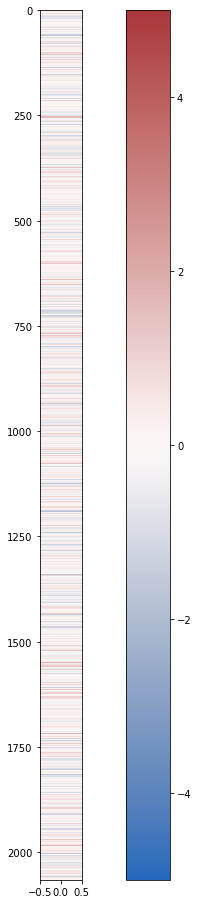

In [14]:
print(tstats_vec)

plt.figure(figsize=(16,16))
plt.imshow(np.reshape(tstats_vec,(nEdges,1)),aspect=.01,cmap='vlag',vmin=-5,vmax=5)
plt.colorbar() 

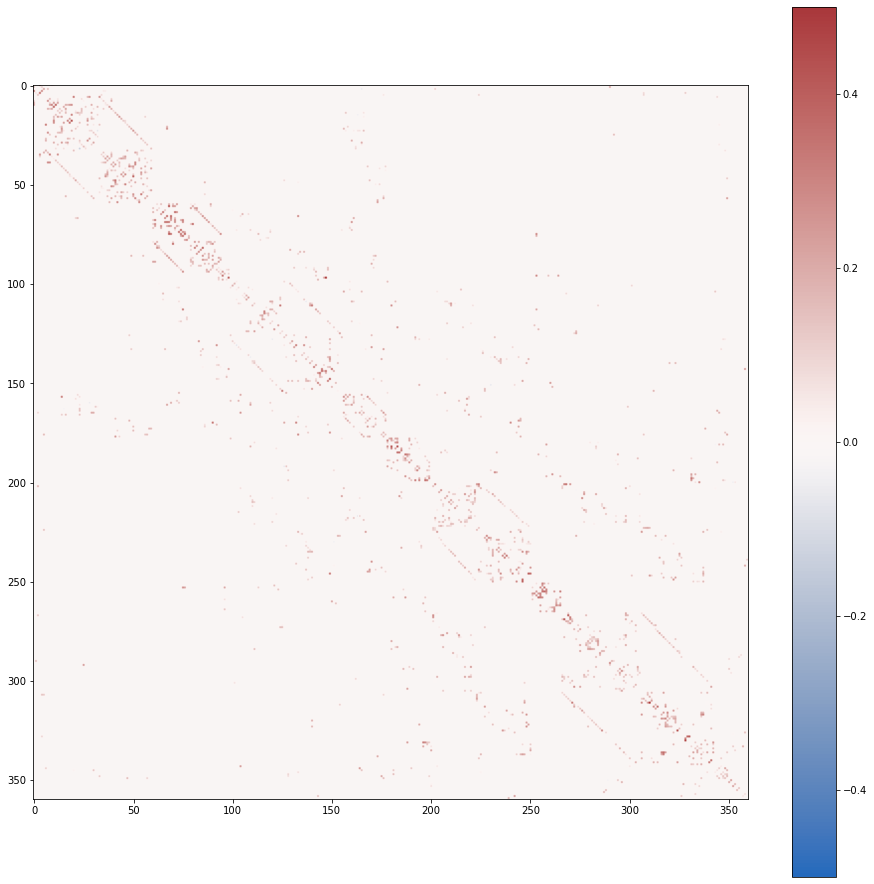

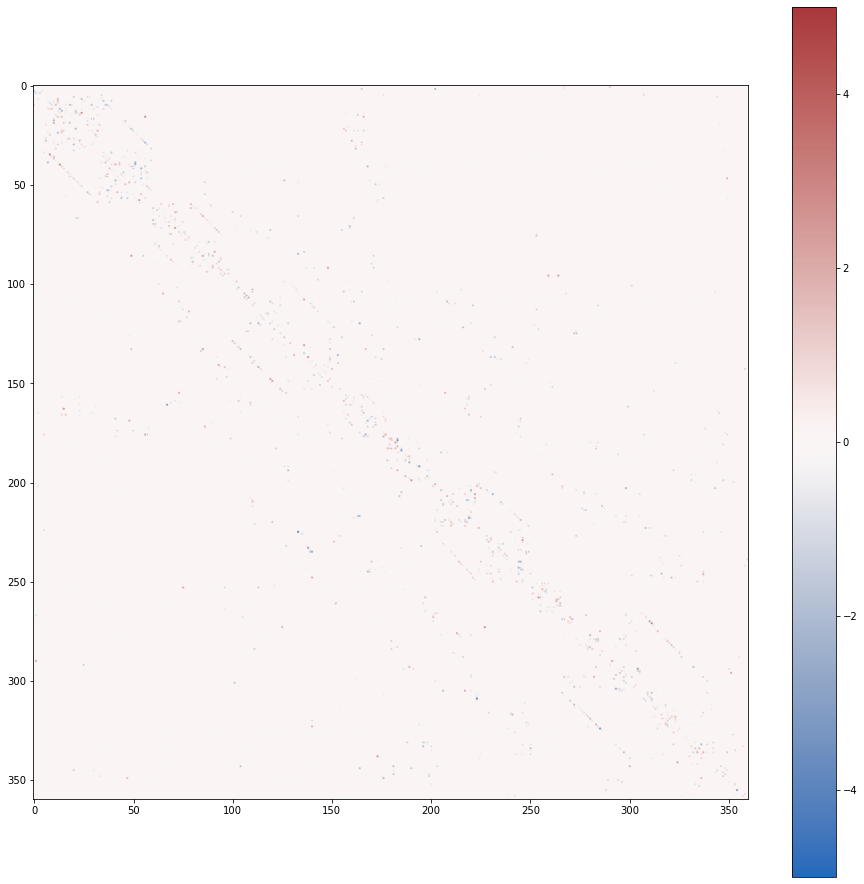

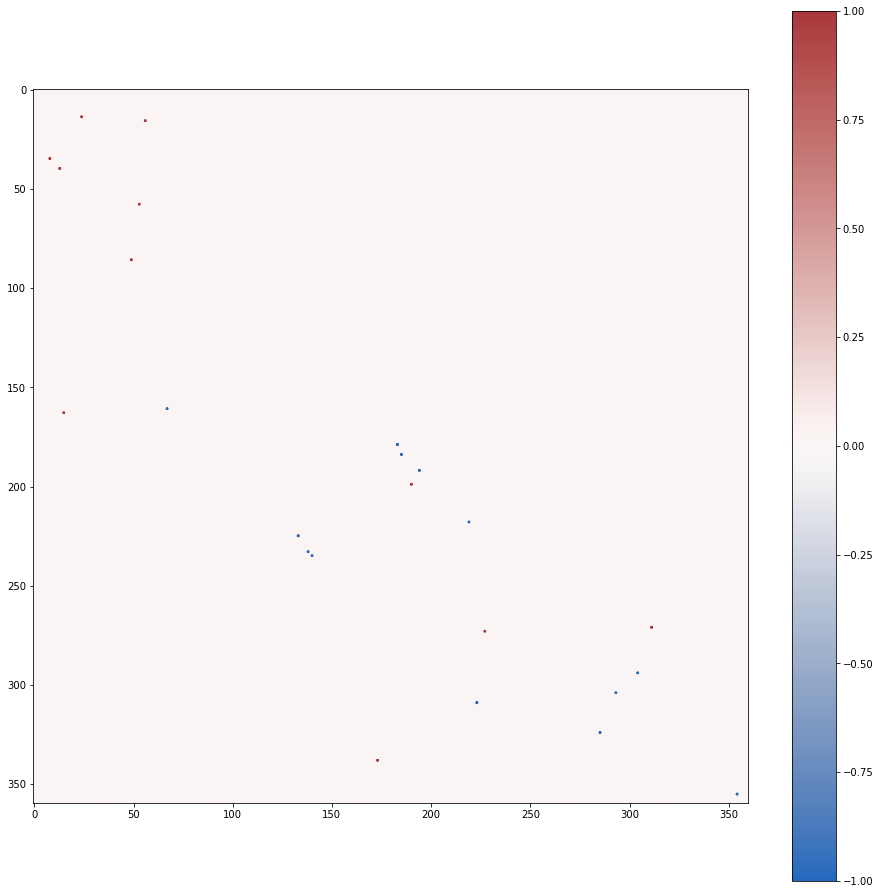

In [49]:
plt.figure(figsize=(16,16))
plt.imshow(np.nanmean(conn,axis=2),cmap='vlag',vmin=-.5,vmax=.5)
plt.colorbar() 

plt.figure(figsize=(16,16))
plt.imshow(tstats_mat[:,:],cmap='vlag',vmin=-5,vmax=5)
plt.colorbar() 

plt.figure(figsize=(16,16))
a = np.zeros((nNodes,nNodes))
a[pvals_mat<.01] = tstats_mat[pvals_mat<.01]
plt.imshow(a,cmap='vlag',vmin=-1,vmax=1)
plt.colorbar() 

In [4]:
conn_nan = np.full((nNodes,nNodes,nSubjs['all']),np.nan)
for s,subj in enumerate(subjList):
    for node in range(nNodes):
        inputs = (nodes!=node) & avgFCEdgeExists[node]
        conn_nan[node,inputs,s] = np.nanmean(np.load(f'{dataDir}/results/{subj}_predSimilarity_node-{node}.npy'),axis=1)[inputs]


targetAvgPred = np.nanmean(conn_nan,axis=1)
inputAvgPred = np.nanmean(conn_nan,axis=0)

targetAvg_T = np.zeros((nNodes))
targetAvg_p = np.zeros((nNodes))
inputAvg_T = np.zeros((nNodes))
inputAvg_p = np.zeros((nNodes))

for node in range(nNodes):
    targetAvg_T[node],targetAvg_p[node] = stats.ttest_ind(targetAvgPred[node,subjGroup=='YA'],targetAvgPred[node,subjGroup=='OA'],nan_policy='omit')
    inputAvg_T[node],inputAvg_p[node] = stats.ttest_ind(inputAvgPred[node,subjGroup=='YA'],inputAvgPred[node,subjGroup=='OA'],nan_policy='omit')
    
    

/tmp/ipykernel_23187/1170026785.py:5: RuntimeWarning: Mean of empty slice
  conn_nan[node,inputs,s] = np.nanmean(np.load(f'{dataDir}/results/{subj}_predSimilarity_node-{node}.npy'),axis=1)[inputs]
/tmp/ipykernel_23187/1170026785.py:8: RuntimeWarning: Mean of empty slice
  targetAvgPred = np.nanmean(conn_nan,axis=1)
/tmp/ipykernel_23187/1170026785.py:9: RuntimeWarning: Mean of empty slice
  inputAvgPred = np.nanmean(conn_nan,axis=0)


In [15]:
targetAvg_p_FDRCorrected = sm.stats.multipletests(targetAvg_p,alpha=.05,method='fdr_bh')
print(sum(targetAvg_p_FDRCorrected[0]))

print(sum(targetAvg_p < .05))
print(sum(targetAvg_p < .01))
print(sum(targetAvg_p < .001))
print(sum(targetAvg_p < .0001))
print()

sig = targetAvg_p < .01

for node in nodes[sig]:
    print(f'{nodeLabels[node]} ({nodeNets[node]}) < ...')
    print(f'YA Avg: {np.nanmean(targetAvgPred[node,subjGroup=="YA"]):.4f}, OA Avg: {np.nanmean(targetAvgPred[node,subjGroup=="OA"]):.4f}')
    print(f'T = {targetAvg_T[node]:.4f}, p = {targetAvg_p[node]:.6f}')
    print()

0
20
4
1
0

Visual2-54_L-Ctx (Visual2) < ...
YA Avg: 0.0525, OA Avg: 0.0536
T = -2.7179, p = 0.008649

Cingulo-Opercular-51_L-Ctx (Cingulo-Opercular) < ...
YA Avg: 0.0836, OA Avg: 0.0847
T = -3.6247, p = 0.000611

Default-62_L-Ctx (Default) < ...
YA Avg: 0.1426, OA Avg: 0.1414
T = 3.2079, p = 0.002178

Default-04_R-Ctx (Default) < ...
YA Avg: 0.1480, OA Avg: 0.1493
T = -3.2375, p = 0.001996






Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii was 0.060202 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.035692 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.pial_MSMAll.32k_fs_LR.surf.gii was 0.03526 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.019829 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii was 0.057956 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.03397 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.R.pial_MSMAll.3

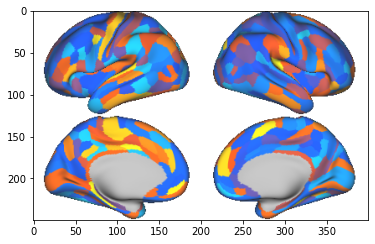

In [17]:
import matplotlib.image as mpimg
from utils.get_network_info import get_network_info
from utils.print_wb_scene import print_wb_scene
from utils.mapToSurface import map_to_surface
from utils.remove_border import remove_border

map_to_surface(targetAvg_T[origOrder],'AvgTargetPredictions',fliphemispheres=False)
filename = '/projects/f_mc1689_1/AgingHubs/docs/scripts/AvgTargetPredictions.dscalar.nii'
print_wb_scene(filename,'AvgTargetPredictions',inflation='inflated')
img = mpimg.imread('AvgTargetPredictions.png')
imgPlot = plt.imshow(img)




Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii was 0.059641 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.035973 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.pial_MSMAll.32k_fs_LR.surf.gii was 0.035184 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.019908 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii was 0.057569 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.034432 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.R.pial_MSMAll

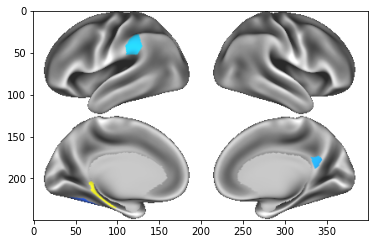

In [18]:
A = np.full((nNodes),np.nan)
A[sig] = targetAvg_T[sig]

map_to_surface(A[origOrder],'AvgTargetPredictions',fliphemispheres=False)
filename = '/projects/f_mc1689_1/AgingHubs/docs/scripts/AvgTargetPredictions.dscalar.nii'
print_wb_scene(filename,'AvgTargetPredictions',inflation='inflated')
img = mpimg.imread('AvgTargetPredictions.png')
imgPlot = plt.imshow(img)

In [19]:
inputAvg_p_FDRCorrected = sm.stats.multipletests(inputAvg_p,alpha=.05,method='fdr_bh')
print(sum(inputAvg_p_FDRCorrected[0]))

print(sum(inputAvg_p < .05))
print(sum(inputAvg_p < .01))
print(sum(inputAvg_p < .001))
print(sum(inputAvg_p < .0001))
print()

sig = inputAvg_p < .01

for node in nodes[sig]:
    print(f'... < {nodeLabels[node]} ({nodeNets[node]})')
    print(f'YA Avg: {np.nanmean(inputAvgPred[node,subjGroup=="YA"]):.4f}, OA Avg: {np.nanmean(inputAvgPred[node,subjGroup=="OA"]):.4f}')
    print(f'T = {inputAvg_T[node]:.4f}, p = {inputAvg_p[node]:.6f}')
    print()

1
18
4
1
1

... < Dorsal-Attention-02_R-Ctx (Dorsal-Attention)
YA Avg: 0.1761, OA Avg: 0.1772
T = -2.6690, p = 0.009849

... < Frontoparietal-33_L-Ctx (Frontoparietal)
YA Avg: 0.1472, OA Avg: 0.1482
T = -4.3213, p = 0.000062

... < Auditory-06_R-Ctx (Auditory)
YA Avg: 0.1635, OA Avg: 0.1621
T = 2.9809, p = 0.004195

... < Orbito-Affective-04_L-Ctx (Orbito-Affective)
YA Avg: 0.1577, OA Avg: 0.1614
T = -3.2440, p = 0.001958






Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii was 0.059876 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.036246 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.pial_MSMAll.32k_fs_LR.surf.gii was 0.035479 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.019919 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii was 0.058031 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.033972 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.R.pial_MSMAll

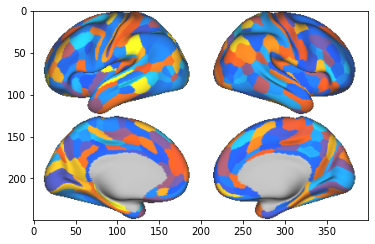

In [20]:
map_to_surface(inputAvg_T[origOrder],'AvgInputPredictions',fliphemispheres=False)
filename = '/projects/f_mc1689_1/AgingHubs/docs/scripts/AvgInputPredictions.dscalar.nii'
print_wb_scene(filename,'AvgInputPredictions',inflation='inflated')
img = mpimg.imread('AvgInputPredictions.png')
imgPlot = plt.imshow(img)





Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii was 0.061075 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.035521 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.pial_MSMAll.32k_fs_LR.surf.gii was 0.034831 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.020184 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii was 0.059352 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.034316 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.R.pial_MSMAll

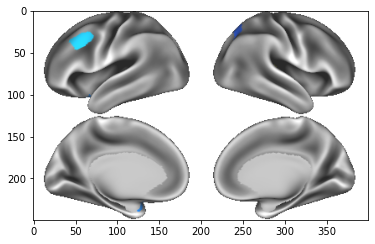

In [21]:
A = np.full((nNodes),np.nan)
A[sig] = inputAvg_T[sig]

map_to_surface(A[origOrder],'AvgInputPredictions',fliphemispheres=False)
filename = '/projects/f_mc1689_1/AgingHubs/docs/scripts/AvgInputPredictions.dscalar.nii'
print_wb_scene(filename,'AvgInputPredictions',inflation='inflated')
img = mpimg.imread('AvgInputPredictions.png')
imgPlot = plt.imshow(img)